<h1>Исследование объявлений о продаже квартир</h1>

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

**Описание данных**: 

    - airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
    - balcony — число балконов
    - ceiling_height — высота потолков (м)
    - cityCenters_nearest — расстояние до центра города (м)
    - days_exposition — сколько дней было размещено объявление (от публикации до снятия)
    - first_day_exposition — дата публикации
    - floor — этаж
    - floors_total — всего этажей в доме
    - is_apartment — апартаменты (булев тип)
    - kitchen_area — площадь кухни в квадратных метрах (м²)
    - last_price — цена на момент снятия с публикации
    - living_area — жилая площадь в квадратных метрах(м²)
    - locality_name — название населённого пункта
    - open_plan — свободная планировка (булев тип)
    - parks_around3000 — число парков в радиусе 3 км
    - parks_nearest — расстояние до ближайшего парка (м)
    - ponds_around3000 — число водоёмов в радиусе 3 км
    - ponds_nearest — расстояние до ближайшего водоёма (м)
    - rooms — число комнат
    - studio — квартира-студия (булев тип)
    - total_area — площадь квартиры в квадратных метрах (м²)
    - total_images — число фотографий квартиры в объявлении

**План работы**: начнем со знакомства с данными, далее проведем предобработку: разребемся с пропущенными значениями и поменяем типы данных, отдельно - добавим новые столбцы в таблицу, затем приступим к самому объемному и важному пункту - исследовательскому анализу данных, в рамках которого мы ответим на многие вопросы: какие значения выбиваются из таблицы, что влияет на цену квартиры сильнее всего, где самое дорогое жилье и где кончается центр Петербурга, закончим работу общими выводами. 

<h3>Оглавление</h3>


1. [Шаг 1: Первичный обзор данных, получение общей информации о данных](#start)   
2. [Шаг 2: Предобработка данных](#preproc)   
    * [Работа с пропущенными значениями](#skipped)   
    * [Изменение типов данных](#changed)     
3. [Шаг 3: Добавление новых столбцов](#adding)
4. [Шаг 4: Исследовательский анализ данных](#research)
    * [Удаление редких и выбивающихся значений: изучение параметров](#delete)
    * [Изучение влияния различных факторов на цену квартиры](#factors)
    * [Поиск населенного пункта с самой высокой и низкой стоимостью жилья](#locality_search)
    * [Определение центральной зоны Петербурга ](#center)
    * [Сравнение параметров центральной зоны Петербурга и параметров всего города ](#spb)
5. [Шаг 5: Общие выводы](#conq)

<h3> Шаг 1: Первичный обзор данных, получение общей информации о данных </h3>
<a id='start'></a>

Импортируем необходимые нам библиотеки, сохраним таблицу в переменную и вызовем к ней метод info() для получения общей информации о таблице.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
estate = pd.read_csv('/datasets/real_estate_data.csv')
estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 1 columns):
total_images	last_price	total_area	first_day_exposition	rooms	ceiling_height	floors_total	living_area	floor	is_apartment	studio	open_plan	kitchen_area	balcony	locality_name	airports_nearest	cityCenters_nearest	parks_around3000	parks_nearest	ponds_around3000	ponds_nearest	days_exposition    23699 non-null object
dtypes: object(1)
memory usage: 185.3+ KB


Как видно по результату работы метода info() полученная нами таблица содержит всего 1 столбец с очень длинным названием, это говорит о том, что строки 'склеились': метод read_csv неверно распознал разделитель столбцов, значит - он в данном файле не стандартный. Посмотрим на первые 5 строк этой таблицы и посмотрим, какой разделитель используется в данном документе.

In [3]:
estate.head()

,total_images\tlast_price\ttotal_area\tfirst_day_exposition\trooms\tceiling_height\tfloors_total\tliving_area\tfloor\tis_apartment\tstudio\topen_plan\tkitchen_area\tbalcony\tlocality_name\tairports_nearest\tcityCenters_nearest\tparks_around3000\tparks_nearest\tponds_around3000\tponds_nearest\tdays_exposition
0,20\t13000000.0\t108.0\t2019-03-07T00:00:00\t3\...
1,7\t3350000.0\t40.4\t2018-12-04T00:00:00\t1\t\t...
2,10\t5196000.0\t56.0\t2015-08-20T00:00:00\t2\t\...
3,0\t64900000.0\t159.0\t2015-07-24T00:00:00\t3\t...
4,2\t10000000.0\t100.0\t2018-06-19T00:00:00\t2\t...


Итак, в качестве разделителя используется сочетание '\t'. Вызовем метод read_csv еще раз, пересохраним таблицу в переменную, но передав это значение в качестве аргумента. 

In [4]:
estate = pd.read_csv('real_estate_data.csv', sep='\t')

Вызовем метод info к новой таблице.

In [5]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Итак, все получилось. Посмотрим также на первые 10 строк новой таблицы.

In [6]:
estate.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


**Выводы по Шагу 1**: на данном шаге мы просмотрели общую информацию о нашей таблице и посмотрели ее первые строки, можем сделать первые выводы о проблемах в данных по увиденному: в таблице присутствуют пропущенные значения, причем в большом количестве, типы данных некоторых столбцов не соответствуют семантике вопроса, так, например, столбец, содержащий дату публикации объявления, имеет тип данных object. Все это мы исправим на следующем шаге. 

<h3> Шаг 2: Предобработка данных </h3>
<a id='preproc'></a>

<h3> Работа с пропущенными значениями </h3>
<a id='skipped'></a>

Итак, как было установлено на предыдущем шаге, наши данные содержат в себе много пропусков. Всего в датасете 22 колонки, из них 14 имеют пропуски. 

Поделим наши пустые ячейки условно на 4 типа и займемся каждым по очереди. Во-первых, разделим колонки, содержащие пропуски, по признаку 'Как заполнялись значения в данной колонке? (автоматически/пользователем)', во-вторых, разделим столбцы с пропусками по свойству 'Сигнализируют ли пропущенные в данном поле значения об отсутствии данных или о нулевом значении параметра?'.

Определим и рассмотрим подробнее пропуски в колонках, которые можно отнести к типу 'заполняемые пользователем + сигнализируют об отсутствии данных', такие как, например, высота потолка, ведь очевидно, не все владельцы квартиры знают высоту потолоков и/или считают нужным, указать эти сведения, НО высота потолка не равна нулю. Отнесем к колонкам, содержащим такие значения, следующие: ceiling_height, floors_total (хотя конкретно в этом столбце возможно автозаполнение по адресу дома, но мы будем придерживаться обозначенной выше точки зрения, другой), living_area, kitchen area, locality_name.

Как было обозначено выше, причины пропусков в этих пяти колонках - отсутствие информации по причине того, что ее не предоставили пользователи. Тактика по работе с пропущенными значениями в данных столбцах: строки, где пропущено значение в поле locality_name, мы удалим, потому что, расположение квартиры сильно влияет на ее цену, а наша задача - научиться определять рыночную стоимость недвижимости, да и процент таких записей - небольшой; значения в living_area и kitchen_area - заполним средними значениями по общей площади (потому что :а) мы можем, так как значения в данных колонках зависят от значений в другой, б) нам эти столбцы еще пригодятся и поэтому, лучше бы им не иметь пропуски); строки с пропуском в floors_total мы тоже удалим: нам потребуется этот столбец в дальнейшим и, как и в ситуации с locality_name, процент таких записей мал; ceiling_height мы трогать не будем - в данной таблице нет информации, на основании которой мы можем заполнить ячейки.

Начнем с удаления строк.

In [7]:
estate = estate.dropna(subset = ['locality_name', 'floors_total']).reset_index(drop=True)

Для заполнения ячеек в living_area и kitchen_area нам необходимо категоризировать квартиры по площади.  Результат категоризации занесем в отдельный столбец, который потом удалим. 

In [8]:
estate['helper'] = pd.qcut(estate['total_area'], 10, labels = [1,2,3,4,5,6,7,8,9,10])

Посчитаем среднюю площадь кухни и жилого помещения для каждой группы, полученные значения занесем в пустые ячейки.

In [9]:
estategrouped = estate.groupby('helper').agg({'kitchen_area': 'mean' , 'living_area': 'mean'})

In [10]:
for i in range(1,11):
    estate[estate['helper'] == i ] = estate[estate['helper'] == i ].fillna(value={'kitchen_area': round(estategrouped.loc[i-1, 'kitchen_area'],2),
                                                                                  'living_area': round(estategrouped.loc[i-1, 'living_area'],2)})

Удалим вспомогательный столбец.

In [11]:
estate = estate.drop(columns=['helper'])

Следующая группа полей с пустыми ячейками это 'заполняемые пользователем + сигнализируют о нулевом значении'. В контексте данного деления будем рассматривать не только арифметический ноль, но и логический - 'ложь'. Эта оговорка позволит нам очень удобно поделить все столбцы с пропущенными значениями. Отнесем к этому типу: is_apartment (если продаются апартаменты, хозяин обязательно должен был бы это указать, поскольку разница между таким видом жилья и квартирой очень существенная, так что делаем вывод - отсутствие пометки о том, что на продаже именно апартаменты, сигнализирует о том, что это не они), balcony (логически размышляя, можно прийти к выводу, что отсутствие данных  о количестве балконов говорит об их отсутствии, хотя данный столбец и можно отнести к предыдущему типу, но мы оставим его здесь). 

Итак, причины пропусков в этих двух колонках - попытка сигнализировать о нуле, но вот в таком, своеобразном виде. Поменяем NaN в is_apartment на False, а в balcony на 0. 

In [12]:
estate = estate.fillna(value={'is_apartment':'False', 'balcony': 0})


Чтобы проверить, все ли получилось, вызовем метод info к таблице.

In [13]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null object
rooms                   23565 non-null int64
ceiling_height          14481 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null object
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null float64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_around30

Все в порядке, идем дальше. Пора переходит к столбцам, значения которых заполнялись автоматически. Их 7. Обратим внимание на одну особенность - в столбцах airports_nearest, cityCenters_nearest, parks_around3000 и ponds_around3000 практически одинаковое количество ненулевых значений (значит и пропущенных тоже). Это вполне может обозначать, что большая часть пустых ячеек в одних и тех же строках, т.е. если значения пропускаются, то во всех столбцах, данные в которых определяются автоматически по картографическим данным. Проверим это. 

Чтобы посмотреть, правдиво ли данное убеждение, найдем соотношение количества строк, в которых значения пропущены в каждом из четырех полей, к количеству строк, в которых пропущены значения в колонке airports_nearest. 

In [14]:
all_skipped = estate[(estate['airports_nearest'].isna()) & (estate['cityCenters_nearest'].isna()) & 
                     (estate['parks_around3000'].isna()) & (estate['ponds_around3000'].isna())].shape[0]
'{:.1%}'.format(all_skipped / estate[estate['airports_nearest'].isna()].shape[0])

'99.6%'

Итак, почти во всех строках, где пропущено значение в airports_nearest, также пропущены и значения в других трех полях: cityCenter_nearest, parks_around3000 и ponds_around3000. 

Другое количество пропущенных значений (большее) в столбцах parks_nearest и ponds_nearest можно объяснить тем, что допустимое значение данного поля еще сверху ограничено какой-то цифрой. Проверим и это тоже. (days_exposition пока не рассматриваем)
Посмотрим, какими цифрами ограничены сверху значения полей parks_nearest и ponds_nearest, для этого отсортируем датафрейм по очереди по этим столбцам по убыванию и посмотрим на первые строки.

In [15]:
estate.sort_values(by='parks_nearest', ascending=False).head(1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
10898,9,3000000.0,31.1,2017-03-21T00:00:00,1,NaN,5.0,17.7,2,False,...,5.5,0.0,Санкт-Петербург,14821.0,9734.0,0.0,3190.0,1.0,431.0,234.0


In [16]:
estate.sort_values(by='ponds_nearest', ascending=False).head(1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20610,7,3250000.0,35.0,2018-08-30T00:00:00,1,2.55,7.0,16.4,1,False,...,7.8,0.0,посёлок Стрельна,28377.0,23562.0,1.0,1073.0,1.0,1344.0,81.0


Итак, получаем, что значение поля parks_nearest ограничено сверху значением 3190 метров, а ponds_nearest - 1344 м. Не сильно много: 3,2 и 1,3 км соответственно. Полученные значения вполне согласуются с нашей теорией. 

Резюмируя полученную информацию, можно сделать один вывод и одно предположение. Во-первых, имеем факт: для каких-то объявлений (адресов) не сработало автозаполнение по картографическим данным, во-вторых, для колонок ponds_nearest и parks_nearest можно предположить что, часть пропущенных значений в них - также результат несработавшего автоопределения по карт. данным, а другая часть это результат того, что если пруд находится дальше 1344 метров, а парк - дальше 3190 метров, то в эту ячейку ставится значение NaN, при этом в колонку-сосед (parks_around3000 или ponds_around3000) попадает значение 0.0. То есть, расстояния до ближайшего пруда/парка не существует, поэтому количество прудов/парков в радиусе 3 километров равно 0. Давайте докажем это, так мы получим более полную картину о наших пустых ячейках.

Если наше предположение верно, то, если в поле ponds_nearest стоит NaN, то в ponds_around3000 стоит либо значение 0.0, либо NaN, аналогично и для второй пары. Убедимся в этом.

In [17]:
estate[estate['ponds_nearest'].isna()]['ponds_around3000'].unique()

array([ 0., nan])

In [18]:
estate[estate['parks_nearest'].isna()]['parks_around3000'].unique()

array([ 0., nan])

Итак, наше предположение верно. Приступим к следующему шагу. 

Посмотрим, для каких населенных пунктов автоопределение по картографическим данным не срабатывает чаще. 

In [19]:
no_map_estate = estate[(estate['airports_nearest'].isna()) &
       (estate['cityCenters_nearest'].isna()) & 
       (estate['parks_around3000'].isna()) & 
       (estate['ponds_around3000'].isna())]['locality_name'].value_counts().head(15)

In [20]:
no_map_estate

посёлок Мурино             520
Всеволожск                 398
Гатчина                    307
деревня Кудрово            299
Выборг                     237
Кудрово                    171
деревня Новое Девяткино    143
Сертолово                  142
Кириши                     125
Сланцы                     112
Волхов                     111
Кингисепп                  104
Тосно                      104
Никольское                  93
Коммунар                    89
Name: locality_name, dtype: int64

Какие могут быть причины именно такого списка? Обратившись к карте, было выяснено, что Мурино это в черте Петербурга, а Выборг - очень далеко. Что же объединяет все это пункты? Увы и ах, занимательный вечер за географией Ленинградской области ответа не дал, примем факт - для некоторых населенных пунктов автозаполнение не срабатывает. Необходимо передать информацию в сервис Яндекс.Недвижимость, а нам - принять отсутствие данных значений. Но перед этим сделаем еще одну вещь - посмотрим, для всех ли объявлений из i-того населенного пункта не определились параметры, может быть, на 522 неполных записей о квартирах из Мурино у нас 5220 заполненных. После этого наш вердикт будет четок. 

Поскольку количество пропущенных значений в столбцах airports_nearest, cityCenter_nearest, parks_around3000 и ponds_around3000 примерно одинаковое, будем в дальнейшем ориентироваться на один из них - airports_nearest. 

Посчитаем количество объявлений о квартирах, расположенных в населенных пунктах из нашего списка no_map_estate, где значение в столбце airports_nearest не пропущено.Также посчитаем, какой процент пропущенных значений в столбце содержат именно строки со значениями locality_name из нашего списка.

In [21]:
sum = 0
for i in range(len(no_map_estate)):
    print(no_map_estate.index[i] 
         + ' : '
         + str(estate[(estate['locality_name'] == no_map_estate.index[i]) & (estate['airports_nearest'].notna())].shape[0])
         + ' без пропущенных значений и '
         + str(no_map_estate[i])
         + ' с пропущенными')
    sum+=no_map_estate[i]
print('{:.1%}'.format(sum / estate[estate['airports_nearest'].isna()].shape[0]))

посёлок Мурино : 0 без пропущенных значений и 520 с пропущенными
Всеволожск : 0 без пропущенных значений и 398 с пропущенными
Гатчина : 0 без пропущенных значений и 307 с пропущенными
деревня Кудрово : 0 без пропущенных значений и 299 с пропущенными
Выборг : 0 без пропущенных значений и 237 с пропущенными
Кудрово : 0 без пропущенных значений и 171 с пропущенными
деревня Новое Девяткино : 0 без пропущенных значений и 143 с пропущенными
Сертолово : 0 без пропущенных значений и 142 с пропущенными
Кириши : 0 без пропущенных значений и 125 с пропущенными
Сланцы : 0 без пропущенных значений и 112 с пропущенными
Волхов : 0 без пропущенных значений и 111 с пропущенными
Кингисепп : 0 без пропущенных значений и 104 с пропущенными
Тосно : 0 без пропущенных значений и 104 с пропущенными
Никольское : 0 без пропущенных значений и 93 с пропущенными
Коммунар : 0 без пропущенных значений и 89 с пропущенными
53.5%


Итак, мы убедились, что данные населенные пункты действительно проблемые: для всех из них не существует объявлений, в которых бы сработало автозаполнение по карт. данным. А также мы узнали, что объявления о квартирах, расположенных в этих пятнадцати населенных пунктах, составляют больше половины всех объявлений, в которых не определены значения в данных полях. Как было написано ранее, стоит передать информацию об это в сервис Яндекс.Недвижимость. Но что нам делать с такими строками?

Удалить данные строки было не совсем разумно, невооруженным взглядом видно - процент таких объявлений большой, поэтому стоит принять этот факт, ничего не делая с пропущенными значениями. Мы могли бы часть из них заполнить, например, выяснив как далеко аэропорт Пулково находится от Мурино, но данная работа - весьма объемна, да и сможем мы заполнить только поле про аэропорты, поскольку остальные столбцы зависят от конкретного адреса. Так что, оставляем как есть.

Последняя колонка, которой мы еще не уделили внимания в данном вопросе, это days_exposition. Можно выдвинуть две теории по поводу отсутствия данных в ячейках: во-первых, вдруг объявления еще не сняты, написано, конечно, архив, но может, в него входят и текущие объявления, во-вторых, причиной пропусков может быть технический сбой - просто по каким-то причинам нет доступа к информации о днях, которые висело объявление. Какой бы ни была причина, у нас нет данных, на основании которых мы можем заполнить пропущенные значения в данной колонке. Поэтому их мы тоже просто оставим.

**Вывод по подпункту 'Работа с пропущенными значениями'**: итак, в данном пункте мы работали с пропущенными значениями, а именно: классифицировали их, выдвинули ряд теорий о том, откуда они появились, что-то удалили, что-то заполнили и что-то оставили, а также нашли очень интересную проблему с автоопределением по картографическим данным, которую необходимо передать в сервис. Теперь наши данные выглядят куда симпатичнее, мы осведомлены подробно обо всех оставшихся пустых ячейках, а Яндекс.Недвижимость получила уникальную возможность - доработать автоопределение. Можно приступать к следующему подпункту.

<h3> Замена типов данных </h3>
<a id='changed'></a>

Вызовем метод info к нашей таблице и обратим внимание на типы данных полей. Как было обозначено ранее, не все типы соответствуют семантике столбца. Определим такие. 

In [22]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null object
rooms                   23565 non-null int64
ceiling_height          14481 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null object
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null float64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_around30

Итак, поля с которыми необходимо провести замену типов данных: first_day_exposition: object -> datetime; floors_total: float -> int; is_apartment: object -> bool; balcony: float -> int. Мы могли бы поменять типы данных столбцов parks_around3000, ponds_around3000, days_exposition, но данные поля содержат NaN'ы, так что мы не можем произвести замену. Довольствуемся тем, что имеем: произведем замену.

In [23]:
estate['floors_total'] = estate['floors_total'].astype('int64')
estate['is_apartment'] = estate['is_apartment'].astype('bool')
estate['balcony'] = estate['balcony'].astype('int64')
estate['first_day_exposition'] = pd.to_datetime(estate['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Вызовем метод info еще раз, проверим, все ли получилось.

In [24]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          14481 non-null float64
floors_total            23565 non-null int64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_around

**Вывод по подпункту 'Замена типов данных'**: итак, в данном подпункте мы заменили типы данных некоторых полей на более им подходящие.

**Вывод по Шагу 2 'Предобработка данных'**: на данном шаге мы провели этап предобработки данных: обработали пропущенные значения и изменили типы данных, теперь с нашими данными будет удобнее работать, а результат этой работы будет более качественным. 

<h3> Шаг 3: Добавление новых столбцов </h3>
<a id='adding'></a>

На данном шаге мы добавим в нашу таблицу новые столбцы, которые потребуются нам для дальнейшнего исследования. Они будут содержать: 1) Цену квадратного метра, 2)День недели, месяц и год публикации, 3)Этаж квартиры: первый, последний, другой, 4)Соотношение жилой и общей площади, а также отношение площади кухни к общей. 

Добавим цену квадратного метра, это частное от деления цены на площадь. 

In [25]:
estate['meter_price'] = round(estate['last_price'] / estate['total_area'], 2)

Добавим день недели, месяц и год публикации. 

In [26]:
estate['day_exposition'] = estate['first_day_exposition'].dt.weekday
estate['month_exposition'] = estate['first_day_exposition'].dt.month
estate['year_exposition'] = estate['first_day_exposition'].dt.year

Добавим этаж квартиры, для этого напишем функцию, которая принимает на вход строку датафрейма и возвращает какой этаж: первый, последний или другой, а конкретнее: цифру 1, если этаж первый, 2, если другой, и 3, если последний. Функцию предварительно проверим.

In [27]:
def floor_determiner(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 1
    elif floor == floors_total:
        return 3
    else:
        return 2

In [28]:
estate_check = pd.DataFrame(columns=['floor', 'floors_total'], data=
                           [[1, 12], [13,13], [7, 10]])
estate_check.apply(floor_determiner, axis=1)

0    1
1    3
2    2
dtype: int64

In [29]:
estate['floor_cat'] = estate.apply(floor_determiner, axis=1)

Добавим соотношение жилой и общей площади и отношение площади кухни к общей.

In [30]:
estate['kitchen_relation'] = round(estate['kitchen_area'] / estate['total_area'], 2)
estate['living_relation'] = round(estate['living_area'] / estate['total_area'], 2)

Посмотрим на первые пять строк нашей таблицы и убедимся, что значения в новых столбцах выглядят так, как мы ожидали.

In [31]:
estate.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,meter_price,day_exposition,month_exposition,year_exposition,floor_cat,kitchen_relation,living_relation
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.00,8,True,...,2.0,755.0,NaN,120370.37,3,3,2019,2,0.23,0.47
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.60,1,True,...,0.0,NaN,81.0,82920.79,1,12,2018,1,0.27,0.46
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.30,4,True,...,2.0,574.0,558.0,92785.71,3,8,2015,2,0.15,0.61
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,79.24,9,True,...,3.0,234.0,424.0,408176.10,4,7,2015,2,0.12,0.50
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.00,13,True,...,1.0,48.0,121.0,100000.00,1,6,2018,2,0.41,0.32


Итак, все в порядке.

**Вывод по Шагу 3 'Добавление новых столбцов'**: таким образом, на данном Шаге мы добавили 7 новых столбцов, которые потребуются нам для дальнейшнего исследования, при добавлении мы использовали различные методы: арифметические операции со столбцами, использование метода apply и функции, а также методы работы с датой.

<h3> Шаг 4: Исследовательский анализ данных </h3>
<a id='research'></a>

Вот, наши данные наконец готовы для их использования в решении нашей задачи: они предобработаны и содержат в себе всю необходимую информацию. Вернемся к основной цели данного проекта, для этого выполним несколько пунктов исследовательского анализа на этом Шаге. 

<h3> Удаление редких и выбивающихся значений: изучение параметров</h3>
<a id='delete'></a>

Начнем с изучения следующих параметров: площадь, цена, число комнат, высота потолков и время продажи квартиры. Построим гистограммы для каждого параметра, сделаем выводы из увиденного, а после - удалим редкие и выбивающиеся значения.

Первым столбцом для анализа будет rooms. Построим гистограмму.

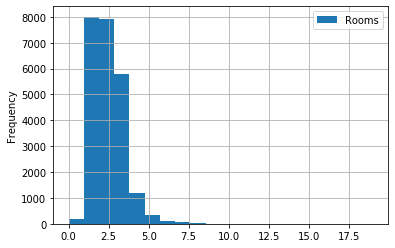

In [32]:
estate.plot(kind='hist', y='rooms', bins=20, grid=True, label='Rooms')

Итак, как видно из полученного графика, большая часть квартир имеет 1 или 2 комнаты, также много трехкомнатных квартир. Можно заметить, что есть выделяющиеся значения, в поиске которых мы и находимся, как минимум - у нас есть одна квартира с 19 комнатами. Чтобы лучше разобраться с такими необычными объявлениями, построим диаграмму размаха для rooms.

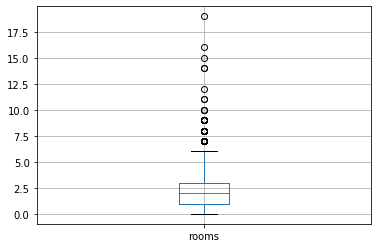

In [33]:
estate.boxplot('rooms')

По диаграмме размаха видно, что колонка содержит в себе необычные значения, которые на графике лежат за пределами 'уса', который лежит в большей части. Нормальные значения же ограничены значением 6. Удалим все записи, в которых количество комнат больше 6. 

In [34]:
estate = estate.drop(estate.query('rooms > 6').index).reset_index(drop=True)

Поработаем над столбцом total_area, построим гистограмму.

In [35]:
estate['total_area'].max()

507.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014542BC3448>]],
      dtype=object)

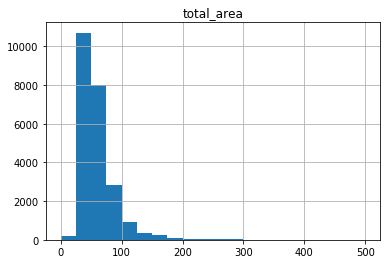

In [36]:
estate.hist('total_area', bins=20, range=(0,500))

По гистограмме, построенной по параметру total_area (площадь квартиры), заметно, что большая часть квартир, выставленных на продажу, имеет площадь от 25 до 50 квадратных метров, ощутимая часть имеет площадь между 50 и 75 квадратными метрами и между 75 и 100 кв. метрами, совсем немного квартир имеет площадь свыше 100 кв. метров. Также интересная особенность - существуют квартиры с площадью меньше 25 квадратных метров. Построим для данного столбца диаграмму размаха для поиска аномалий, но перед этим займемся маленькими квартирами, ведь такая небольшая площадь тоже может быть выбивающимся значением. 

Первым делом, найдем ошибки, сразу бросающиеся в глаз: рассмотрим строки, для которых площадь квартиры меньше площади кухни сложенной с жилой.

In [37]:
estate.query('total_area < (living_area + kitchen_area)')[['kitchen_area', 'living_area', 'total_area']].head(10)

,kitchen_area,living_area,total_area
116,18.30,79.24,97.20
184,6.20,26.10,30.20
422,19.56,88.00,98.00
438,6.77,24.75,27.11
542,5.00,20.00,23.80
548,9.28,30.55,31.59
597,7.00,48.30,53.70
688,23.43,23.43,34.69
689,6.77,17.50,24.10
708,6.77,12.00,17.00


Интересная вещь бросается в глаза - для некоторых квартир одинаковая площадь кухни. Кажется, это наше заполнение пропущенных значений. Ну да ладно, случается. Ошибки в остальных объявлениях вполне могут быть результатами неправильно введенных пользователями данных. Посмотрим, сколько таких строк.

In [38]:
estate.query('total_area < (living_area + kitchen_area)').shape[0]

233

Не так уж и много, удалим записи.

In [39]:
estate = estate.drop(estate.query('total_area < (living_area + kitchen_area)').index).reset_index(drop=True)

Вернемся к диаграмме размаха.

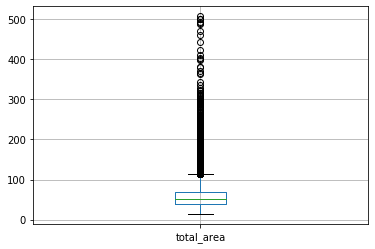

In [40]:
estate.boxplot('total_area')

Диаграмма размаха информирует нас о том, что аномальные значения находятся только в большей части - где-то за 110-115 кв. метрами. Данное число не является особо большим - средняя площадь 3-х комнатной квартиры, поэтому для большей уверенности, мы посмотрим, какая часть квартир в наших объявлениях имеет такую площадь.

In [41]:
str(round(estate.query('total_area > 115').shape[0] / estate.shape[0] * 100, 2)) + '%'

'4.81%'

4,81 процент это достаточно много. Построим гистограмму для значений свыше 100 кв. метров и посмотрим, может быть существует более подходящее место для проведения границы.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014542CFAD48>]],
      dtype=object)

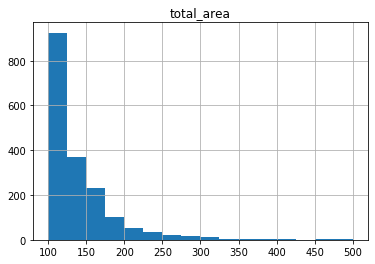

In [42]:
estate.hist('total_area', range=(100,500), bins=16)

Попробуем ограничиться 175 кв. метрами. Посмотрим, какой процент от таблицы составляют значения, не входящие в эту границу.

In [43]:
str(round(estate.query('total_area > 175').shape[0] / estate.shape[0] * 100, 2)) + '%'

'1.13%'

Уже гораздо лучше, так и оставим. Удалим объявления о квартирах с площадью свыше 175 кв. метров.

In [44]:
estate = estate.drop(estate[estate['total_area'] > 175].index).reset_index(drop=True)

Приступим к работе со столбцом last_price, построим гистограмму. 

In [45]:
estate['last_price'].max()

135000000.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014542DD8C48>]],
      dtype=object)

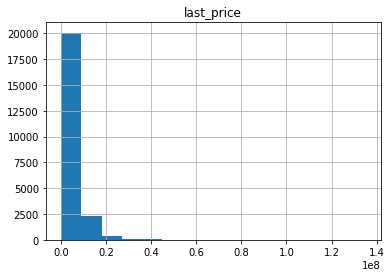

In [46]:
estate.hist('last_price', bins=15)

По гистограмме, построенной по параметру last_price (крайняя цена квартиры), можно сделать вывод: большая часть квартир имеет цену до 9 млн. рублей, небольшая часть имеет цену от 9 до 18 млн.рублей, остальные же значения встречаются редко. Построим диаграмму размаха для столбца, для большей наглядности ограничим ось ординат до 20 млн. рублей, а также более удобную для исследования гистограмму - со значениями от 0 до 18 млн. рублей.

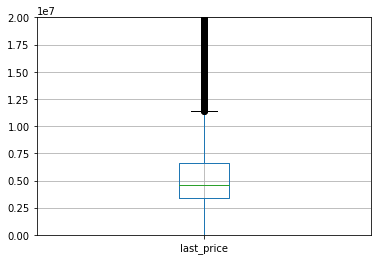

In [47]:
plt.ylim(0, 20000000)
estate.boxplot('last_price')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014543376D08>]],
      dtype=object)

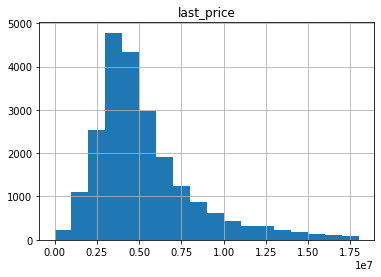

In [48]:
estate.hist('last_price', range=(0,18000000), bins=18)

По двум полученным графикам можно сделать вывод - значения свыше 12,5 млн. рублей выбивающиеся. Удалим строки, содержащие их.

In [49]:
estate = estate.drop(estate.query('last_price > 12500000').index).reset_index(drop=True)

Обратимся к столбцу ceiling_height. Построим гистограмму.

In [50]:
estate['ceiling_height'].max()

32.0

Уже на этапе подготовки к построению гистограммы обнаруживаем очень странное число - высота потолка 32 метра, поэтому ограничим нашу гистограмму по оси ординат для наглядности.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001454345BDC8>]],
      dtype=object)

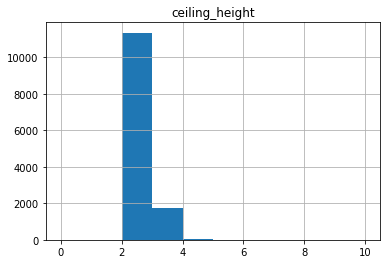

In [51]:
estate.hist('ceiling_height', bins=10, range=(0,10))

По гистограмме, построенной по столбцу ceiling_height (высота потолков), можно сделать следующий вывод: высота потолков большинства квартир от 2 до 3 метров (что, к слову, вполне соответствует реальности), также некоторый ощутимый процент имеет высоту от 3 до 4 метров. Построим диаграмму размаха для поиска аномальных значений.

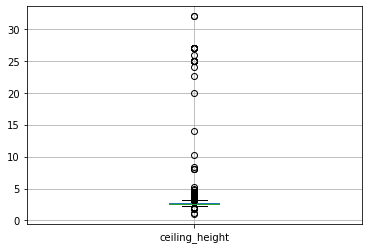

In [52]:
estate.boxplot('ceiling_height')

График не сильно наглядный, но мы уже видим особенности, требущие внимания - значения свыше 7 метров, они, конечно, должны быть удалены в дальнейшем. Ограничим ось ординат для более подробного исследования.

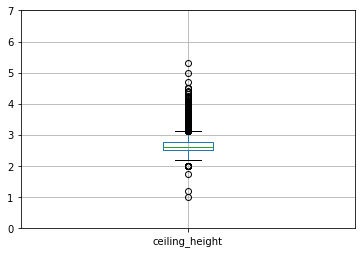

In [53]:
plt.ylim(0, 7)
estate.boxplot('ceiling_height')

Сделаем вывод: у нас есть аномальные значения в нижней части, от них мы избавимся, высота потолка должна составлять не менее 2,1 метров для прихожих; с аномальными значениями в верхней части уже сложнее: наша диаграмма записала туда все числа больше 3, что не совсем корректно, потому что, как минимум, по гистограмме видно, что процент квартир с такими потолками большой, а также, известен факт - для элитного жилья высота потолка свыше 3 метров это нормально. Доверимся нашей гистограмме, а не диаграмме размаха и ограничим высоту потолка сверху значением 4 метра.

In [54]:
estate = estate.drop(estate.query('ceiling_height > 4 or ceiling_height < 2.1').index).reset_index(drop=True)

Изучим время продажи квартиры, построим гистограмму по столбцу days_exposition, а также посчитаем среднее и медиану для этой колонки. 

In [55]:
estate['days_exposition'].max()

1580.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000145435B3E48>]],
      dtype=object)

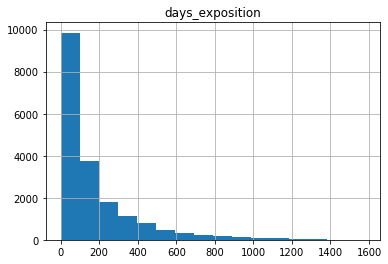

In [56]:
estate.hist('days_exposition', bins=16)

In [57]:
estate['days_exposition'].mean()

174.18563764805864

In [58]:
estate['days_exposition'].median()

92.0

Делаем выводы: большая часть квартир продается в течение ста дней, это видно по гистограмме, а также свидетельствует об этом медиана, равная 92, т.е. половина квартир продается именно за это время; также ощутимый процент жилья находит своего покупателя в период от 100 до 200 дней со дня появления объявления и в период от 200 до 400 дней. Наша задача определить, когда считается, что квартира продалась слишком быстро, а когда - слишком медленно. Сначала мы удалим редкие и выбивающиеся значения, а после - примем как слишком быстрые - меньшие 10 процентов значений, а как слишком долгие - большие 10 процентов. Построим диаграмму размаха для колонки.

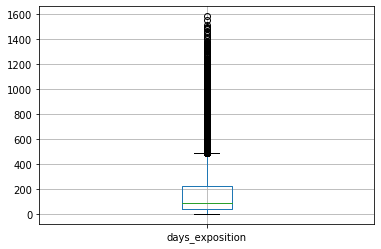

In [59]:
estate.boxplot('days_exposition')

Диаграмма сообщает нам, что в нижней части аномальных значений нет, а вот в верхней - весьма много. Примем редкими значения больше 550 дней - полутора лет, это соответствует информации с диаграммы, а по гистограмме можно убедиться - процент таких записей не критичный. Удалим выбивающиеся значения. 

In [60]:
estate = estate.drop(estate.query('days_exposition > 550').index).reset_index(drop=True)

Посчитаем медиану и среднее заново, но уже методом describe.

In [61]:
estate['days_exposition'].describe()

count    17574.000000
mean       129.976272
std        125.859565
min          1.000000
25%         41.000000
50%         83.000000
75%        183.000000
max        550.000000
Name: days_exposition, dtype: float64

А сейчас приступим к поиску границ. Для определения нижних и верхних 10 процентов используем метод qcut.

In [62]:
pd.qcut(estate['days_exposition'], 10).unique().sort_values()[0]

Interval(0.999, 15.0, closed='right')

In [63]:
pd.qcut(estate['days_exposition'], 10).unique().sort_values()[9]

Interval(331.0, 550.0, closed='right')

Итак, будем считать, что квартиры, проданные меньше, чем за 15 дней - проданы слишком быстро, а квартиры, которые продавались больше 330 дней (около 11 месяцев) - продавались слишком долго.

**Вывод по подпункту**: вот, мы удалили редкие и выбивающиеся значения, а помогли нам с этом гистограммы и диаграммы размаха. Это позволит нам получить более корректные результаты: лучше применимые для часто встречающихся случаев реальной жизни. 

<h3>Изучение влияния различных факторов на цену квартиры</h3>
<a id='factors'></a>

Настало время самого интересного: определим, какие факторы больше всего влияют на стоимость квартиры. Изучим зависимость цены от площади, числа комнат, удалённости от центра, от того, на каком этаже расположена квартира: первом, последнем или другом, от даты размещения: дня недели, месяца и года.

Для почти каждого фактора построим график, разделенный на шестиугольные области, такой, что по оси ординат всегда будет располагаться столбец last_price - цена квартиры, а по оси абсцисс - исследуемый фактор. Также посчитаем коэффициент корреляции для параметра и last_price.

Создадим также на данном шаге новый датафрейм для более удобного вывода на Шаге 5. В него будем вносить название терриории, название фактора и коэф. его влияния: там где возможно, это будет коэф. корреляции, а в остальном - специальный коэффициент, удельный вес сотой которого будет рассчитан далее. 

In [64]:
estate_conq = pd.DataFrame(columns=['area', 'factor', 'coef'], data=[])
estate_conq_len = 0

Напишем функцию, которая строит график hexbin и считает коэф. корреляции для фактора и last_price. Данная функция подойдет не только для таблицы estate, но и для любого ее среза с условием сохранения названия столбца last_price. Также эта функция корректирует наш итоговый датафрейм.

In [65]:
def last_price(data, factor):
    global estate_conq_len
    data.plot(x=factor, y='last_price', kind='hexbin', gridsize=20, sharex=False, grid=True)
    corrcoef = abs(round(data['last_price'].corr(data[factor]),2))
    if data.shape[0] >= 19000:
        area = 'Санкт-Петербург+'
    elif data.shape[0] >= 10000:
        area = 'Санкт-Петербург'
    else:
        area = 'Санкт-Петербург-'
    estate_conq.loc[estate_conq_len] = [area, factor, corrcoef]
    estate_conq_len += 1
    return 'Коэф. корреляции: ' + str(corrcoef)

Начнем с зависимости цены от площади. Строим график и считаем коэффициент Пирсона. 

'Коэф. корреляции: 0.71'

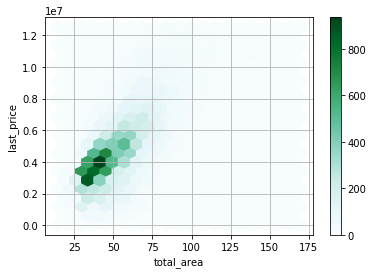

In [66]:
last_price(estate, 'total_area')

Полученный график уже свидетельствует о том, что зависимость между площадью квартиры и ее ценой существует: при определенных значениях total_area параметр last_price принимает некоторые значения куда чаще, чем остальные - об этом говорит нам цвет шестиугольников  - это означает, что есть определенная закономерность, и, как можно заметить, если приглядеться - линейная зависимость; этот факт подтвержает и коэффициент корреляции - он весьма высокий. Делаем вывод - цена квартиры ощутимо зависит от ее площади. 

Посмотрим, что с числом комнат.

'Коэф. корреляции: 0.45'

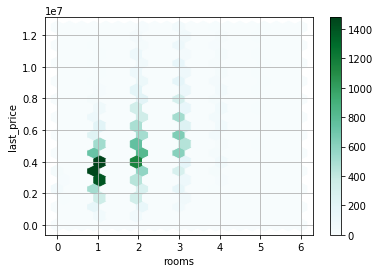

In [67]:
last_price(estate, 'rooms')

График выглядит весьма необычно, но если включить фантазию и провести связь между самыми яркими точками на каждой из линиий, параллельных оси ординат, то можно увидеть что-то вроде прямой, идущей вверх. Это признак линейной зависимости между величинами. Что и подтвержает коэффициент Пирсона - положительный, не маленький. Но все же при рассмотрении данного фактора коэффициент корреляции получился меньше, чем в предыдущем случае. Делаем вывод: цена зависит от количества комнат, но не так сильно, как от площади квартиры. 

Сейчас мы проделаем еще одну вещь - посчитаем среднюю разницу в цене между квартирами с разным кол-вом комнат и поделим на коэф. корреляции. Так мы получим удельный вес сотой коэффициента корреляции и сможем оценивать параметры, для которых он не вычисляется, более справедливо. Логика данного решения следующая: коэффициент Пирсона подходит для линейной зависимости, а нам надо каким-то образом сравнить влияние факторов, не все из которых влияют  именно так; для таких параметров мы и будем использоваться наш аналог коэффицента корреляции. Если полученные значения не будут согласовываться с выводами, которые мы получим из графиков, мы не будем их (взвешенные коэффициенты) учитывать. 

In [68]:
differences = []
for i in range(1, 5):
    differences.append(abs(estate.query('rooms == @i')['last_price'].mean() - 
    estate.query('rooms == (@i + 1)')['last_price'].mean()))

In [69]:
mean_diff = pd.Series(data = differences).mean()
weight = round(mean_diff / 45, 0)

Изучим зависимость цены от удаленности от центра. 

'Коэф. корреляции: 0.35'

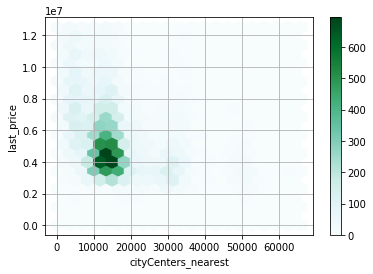

In [70]:
last_price(estate, 'cityCenters_nearest')

Итак, видно, что между величинами отрицательная корреляция. По графику это не так заметно, но все же: большие цены немного чаще встречаются при меньшем расстоянии от центра, кривая уходит вверх при приближении к оси ординат. Значит, цена квартиры зависит от расстояния до центра.

Посмотрим, зависит ли цена квартиры от категории этажа. Вспомним, цифрой 1 мы обозначали первый этаж, цифрой 2 - другой этаж и цифрой 3 - последний.

'Коэф. корреляции: 0.03'

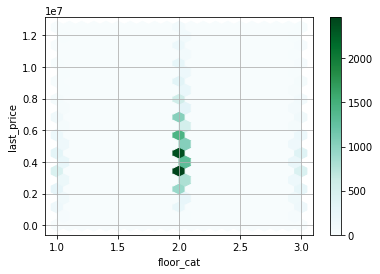

In [71]:
last_price(estate, 'floor_cat')

По графику ничего особо не скажешь, коэффициент корреляции очень маленький. Вывод: цена квартиры не зависит от этажа? Звучит сомнительно, квартира на первом этаже с видом на скамейки у подъезда, очевидно, менее привлекательна, чем квартира с видом на ночной Петербург с 13 этажа. Посчитаем среднюю цену на квартиру для каждой этажной категории и медиану отдельно и занесем в новую таблицу, построим по ней график. Напишем функцию для таких манипуляций, в дальнейшем пригодится. Опять же, она применима для срезов estate с условием сохранения названия столбца last_price. 

Подробнее о функции: как параметры она принимает не только название датасета и фактора, но и список marker - это те значения, которые не надо учитывать при рассчете коэффициента и построении графика, здесь это нужно из-за специфики рассматриваемого вопроса - исследования факторов, кои являются категориальными переменными. В теле функции считается разница между максимальными и минимальными медианными и средними значениями, затем их среднее делится на удельный вес сотой нашего 'коэффициента' - мы получаем аналог коэффициента корреляции. 

In [72]:
def newdf_maker(data, factor, marker=[]):
    global estate_conq_len
    if data.shape[0] >= 19000:
        area = 'Санкт-Петербург+'
    elif data.shape[0] >= 10000:
        area = 'Санкт-Петербург'
    else:
        area = 'Санкт-Петербург-'
    if len(marker)!= 0:
        data = data[~ data[factor].isin(marker)]
    newdf = data.groupby(factor).agg({'last_price': ['mean', 'median']})
    mean_diff = newdf[('last_price', 'mean')].max() - newdf[('last_price', 'mean')].min() 
    median_diff = newdf[('last_price', 'median')].max() - newdf[('last_price', 'median')].min()
    mean_diff_weighted = round(mean_diff / weight, 2)
    median_diff_weighted = round(median_diff / weight, 2)
    estate_conq.loc[estate_conq_len] = [area, factor , round((mean_diff_weighted + median_diff_weighted) / 200, 2)]
    estate_conq_len += 1
    ax = newdf.plot( y=('last_price', 'mean'), label = 'mean_price')
    newdf.plot(y=('last_price', 'median'), ax=ax, grid=True, label = 'median_price')

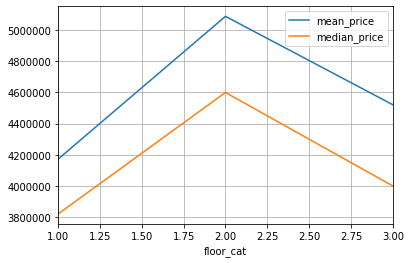

In [73]:
newdf_maker(estate, 'floor_cat')

Получившийся график напоминает квадратичную функцию, поэтому коэффициент Пирсона и 'не взял' эту зависимость - она просто не линейная, но факт ее существования налицо: квартира на первом этаже стоит в среднем почти на миллион (!!!) рублей меньше, чем на этаже, который не является ни первым, ни последним,  квартиры на последних этажах тоже стоят меньше, чем на 'серединочных', но не настолько, как на первых. Вывод: категория этажа, на котором расположена квартира, влияет на ее цену.

Рассмотрим зависимость цены квартиры от дня публикации объявления: от дня недели, месяца и года. Начнем с дня недели.

'Коэф. корреляции: 0.02'

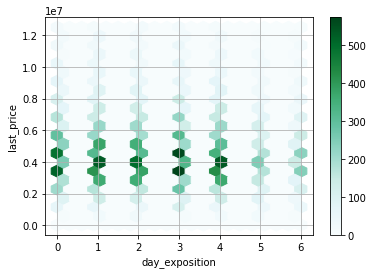

In [74]:
last_price(estate, 'day_exposition')

Как видно по графику, в выходные появляется меньше объявлений, но в остальном - он там не сильно поможет, так что по аналогии с категориями этажей - создадим новую таблицу со средними и медианными ценами и построим график по ней. Также поступим и дня определения зависимости цены квартиры от месяца и года, помимо этого посчитаем коэффициенты корреляции, а вот графики с 'сотами' больше пока строить не будем. 

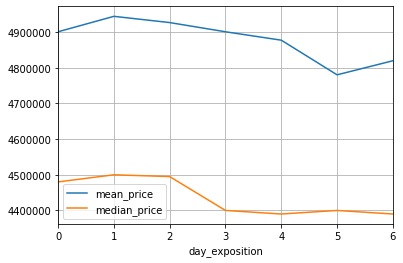

In [75]:
newdf_maker(estate, 'day_exposition')

Коэффициент корреляции для дня недели и цены мы уже считали - он равен '-0.02', т.е. существует небольшая отрицательная зависимость: ближе к концу недели цена квартир в новых объявлениях ниже. Собственно, примерно то же самое мы видим и на нашем графике: медианная цена, начиная с четверга, падает на 100 т.р., средняя - падает с пятницы. 

Посмотрим на зависимость от месяца размещения объявления. 

In [76]:
round(estate['last_price'].corr(estate['month_exposition']),2)

0.0

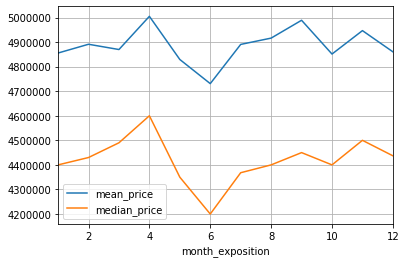

In [77]:
newdf_maker(estate, 'month_exposition')

В общем, в большинстве месяцев цены средние и медианные выравниваются около постоянного значения, но выделяются два месяца: апрель и июнь, в первом цена ощутимо выше медианы, во втором - ниже. Коэффициент корреляции для данных величин равен 0. Зависит ли цена квартиры от месяца, в который появилось объявление об ее продаже? Скорее да, чем нет. Так, в июне можно хорошо сэкономить на покупке. 

И последнее, что осталось рассмотреть - зависимость цены квартиры от года публикации. Действует по тому же механизму. Также проверим, одинаково ли бы было количество объявлений во все года: поскольку сервис развивается, очевидно, что сейчас там ежегодно публикуется больше объявлений, чем раньше. А большая разность между количеством объявлений может влиять на корректность определения закономерности.

In [78]:
round(estate['last_price'].corr(estate['year_exposition']), 2)

0.03

In [79]:
estate['year_exposition'].value_counts()

2018    7838
2017    7268
2019    2603
2016    2014
2015     490
2014       7
Name: year_exposition, dtype: int64

У нас всего 7 объявлений в 2014 году. Не будем его учитывать.

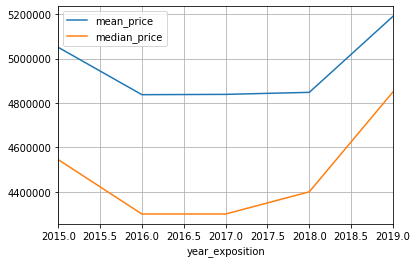

In [80]:
newdf_maker(estate, 'year_exposition', [2014])

Посмотрим, что получилось в нашей итоговой таблице на данный момент - после рассмотрения всего датафрейма. 

Выводы можно сделать весь интересные. Коэффициент корреляции, к слову, опять совсем небольшой. Цены на квартиры упали в 2015 году примерно на 200 т.р, затем оставались постоянными пару лет, а вот к 2019 году произоешл ощутимый рост, так, промедлив год с жильем, за квартиру пришлось бы заплатить на 400 тысяч рублей больше. Цена квартиры зависит от года публикации объявления. 

In [81]:
estate_conq

,area,factor,coef
0,Санкт-Петербург+,total_area,0.71
1,Санкт-Петербург+,rooms,0.45
2,Санкт-Петербург+,cityCenters_nearest,0.35
3,Санкт-Петербург+,floor_cat,0.03
4,Санкт-Петербург+,floor_cat,0.31
5,Санкт-Петербург+,day_exposition,0.02
6,Санкт-Петербург+,day_exposition,0.05
7,Санкт-Петербург+,month_exposition,0.12
8,Санкт-Петербург+,year_exposition,0.17


Параметры floor_cat и day_exposition дважды появились в таблице. Удалим некорректные строки.

In [82]:
estate_conq = estate_conq.drop([3, 5]).reset_index(drop=True)
estate_conq_len -= 2

In [83]:
estate_conq

,area,factor,coef
0,Санкт-Петербург+,total_area,0.71
1,Санкт-Петербург+,rooms,0.45
2,Санкт-Петербург+,cityCenters_nearest,0.35
3,Санкт-Петербург+,floor_cat,0.31
4,Санкт-Петербург+,day_exposition,0.05
5,Санкт-Петербург+,month_exposition,0.12
6,Санкт-Петербург+,year_exposition,0.17


**Какие факторы влияют на цену квартиры больше всего?** Итак, в данном подпункте мы рассмотрели 7 факторов. Для трех из них мы посчитали коэффициент корреляции, а еще для четырех - его аналог. Настало время сделать выводы. Располагая наши факторы, опираясь на значение фактора, по убыванию значимости, мы получим: площадь квартиры, количество комнат, расстояние до центра, категория этажа, год публикации, месяц публикации и день публикации. Полученный результат согласуется с реальностью: действительно, площадь квартиры обычно оказывает большее влияние на ее цену, чем то, в какой день недели было опубликовано объявление.  

Наш аналог коэффициента корреляции был рассчитан с учетом разницы между ценами квартир, принадлежащих к различным категориям. Поэтому числа, полученные в таблице, и согласуются со следующим обоснованием: площадь квартиры, количество комнат в ней, расстояние до центра и категория этажа имеют большее влияние на цену, чем остальные три фактора, потому что, разница между квартирами разной площади, например, может исчисляться миллионами рублей, а разница между ценами одинаковых по всем параметрам квартир, но опубликованных в разные дни недели - сотнями тысяч рублей. 

**Вывод по подпункту**: расположим факторы по степени влияния так: 1) площадь квартиры, 2) число комнат, 3) удаленность от центра, этаж, 4) год публикации. Это параметры, которые влияют сильнее всего на цену квартиры, по порядку.

<h3> Поиск населенного пункта с самой высокой и низкой стоимостью жилья</h3>
<a id='locality_search'></a>

Наша задача в этом подпункте: выбрать 10 населённых пунктов с наибольшим числом объявлений, посчитать среднюю цену квадратного метра в этих населённых пунктах, выделить среди них населённые пункты с самой высокой и низкой стоимостью жилья.

Под нашу задачу создадим новый датафрейм: каждая строка будет содержать название того самого населенного пункта и среднюю цену квадратного метра в нем. 

In [84]:
estate_sqmet = pd.DataFrame(columns=['name', 'sqmeter_price'], data=[])

Найдем такие населенные пункты и их названия занесем в нашу таблицу. Для каждой локации посчитаем среднюю цену квадратного метра и тоже занесем в датафрейм. Посмотрим, что получилось.

In [85]:
temporary = estate['locality_name'].value_counts().head(10).index

In [86]:
for i in range(10):
    village = temporary[i]
    estate_sqmet.loc[i] = [village, 
                          round(estate[estate['locality_name'] == village]['meter_price'].mean(),2)]

In [87]:
estate_sqmet

,name,sqmeter_price
0,Санкт-Петербург,105819.29
1,посёлок Мурино,85492.08
2,посёлок Шушары,78348.53
3,Всеволожск,67081.61
4,Колпино,75170.82
5,Пушкин,100133.28
6,посёлок Парголово,90081.73
7,Гатчина,68509.08
8,деревня Кудрово,92503.25
9,Выборг,57949.05


Найдем в таблице интересующую нас информацию, для этого просто отсортируем ее.

In [88]:
estate_sqmet.sort_values(by='sqmeter_price', ascending=False)

,name,sqmeter_price
0,Санкт-Петербург,105819.29
5,Пушкин,100133.28
8,деревня Кудрово,92503.25
6,посёлок Парголово,90081.73
1,посёлок Мурино,85492.08
2,посёлок Шушары,78348.53
4,Колпино,75170.82
7,Гатчина,68509.08
3,Всеволожск,67081.61
9,Выборг,57949.05


Итак, среди населенных пунктов с наибольшим числом объявлений самая высокая цена за квадратный метр в Санкт-Петербурге, а самая маленькая - в Выборге.

**Вывод по подпункту**: итак, в данном разделе мы нашли населенный пункт с самой большой стоимостью квадратного метра и населенный пункт с самой маленькой ценой за квадратный метр; лидер рейтинга никого не удивит - квартира в культурной столице вряд ли может стоить сильно дешево, а вот факт того, что кв. метр в Выборге стоит почти в два раза меньше, немного поражает. Неужели это настолько далеко? ... 

<h3>Определение центральной зоны Петербурга</h3>
<a id='center'> </a>

Итак, наша следующая задача в рамках этого проекта: выделить квартиры в Санкт-Петербурге, выяснить, какая область входит в центр. 

Мы создадим столбец с расстоянием до центра в километрах, после этого посчитаем среднюю цену для каждого километра, построим график: он должен показывать, как цена зависит от удалённости от центра. Определим границу, где график сильно меняется — это и будет центральная зона.

Для начала сделаем срез квартир в Петербурге, далее будем работать только с ним. Сохраним его в отдельную переменную.

In [89]:
estate_sp = estate[estate['locality_name'] == 'Санкт-Петербург'].reset_index(drop=True)

Создадим новый столбец с целочисленными значениями километров до центра. Напишем функцию для этого.

In [90]:
def rounder(kilom):
    return round(kilom/1000,0)

In [91]:
rounder(1002)

1.0

In [92]:
estate_sp['kilo_center'] = estate_sp['cityCenters_nearest'].apply(rounder)

Сгруппируем таблицу по столбцу kilo_center, посчитаем среднюю цену для каждого километра и построим график.

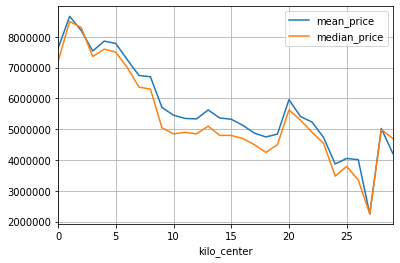

In [93]:
newdf_maker(estate_sp, 'kilo_center')

Сделаем вывод: график сильно меняется 7-8 километре, значит, центр ограничен значением 8 км.

**Вывод по подпункту**: итак, в данном подпункте мы определили центральную зону Петербурга, не обращаясь к картам: центр ограничен радиусом 8 километров, невероятно!

<h3>Сравнение параметров центральной зоны Петербурга и параметров всего города</h3>
<a id='spb'></a>

Итак, в прошлом пункте мы выделили центральную зону города. Нам необходимо проанализировать эту территорию и изучить следующие параметры: площадь, цена, число комнат, высота потолков; выделить факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления), сделать выводы и сравнить их с общими выводами по всему городу.

Первым делом - сделаем срез квартир, расположенных в центре и изучим его.

In [94]:
estate_spc = estate_sp.query('kilo_center <=8').reset_index(drop=True)

Построим гистограммы для столбцов total_area, last_price, rooms, ceiling_height и сделаем по ним выводы.

In [95]:
estate_spc['total_area'].max()

167.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000145453634C8>]],
      dtype=object)

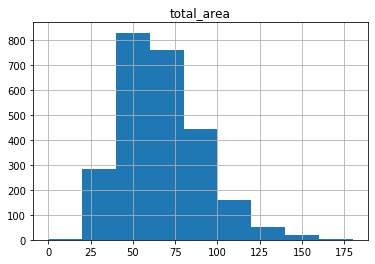

In [96]:
estate_spc.hist('total_area', range=(0,180), bins=9)

Итак, большая часть квартир в центре имеет площадь от 40 до 60 кв. метров, почти столько же квартир с площадью от 60 до 80 кв. метров, также существенное количество квартир с площадью от 80 до 100 кв. метров.

In [97]:
estate_spc['rooms'].max()

6

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001454276D788>]],
      dtype=object)

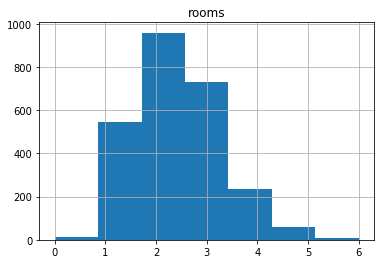

In [98]:
estate_spc.hist('rooms', bins=7)

Итак, в центре больше всего двухкомнатных квартир, также много и трехкомнатных, при этом, их, на удивление, больше, чем однокомнатных. Вспомним, что по всей выборке однокомнатных почти столько же сколько и двухкомнатных.

In [99]:
estate_spc['last_price'].max()

12500000.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014544D9C4C8>]],
      dtype=object)

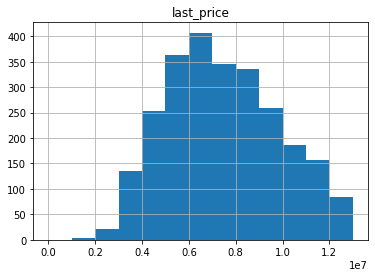

In [100]:
estate_spc.hist('last_price', bins = 13, range=(0,13000000))

Итак, большая часть квартир имеет цену от 6 до 7 млн. рублей, также много квартир с ценами от 5 до 6 млн. рублей и от 7 до 9 млн. рублей. 

In [101]:
estate_spc['ceiling_height'].max()

4.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014542DC43C8>]],
      dtype=object)

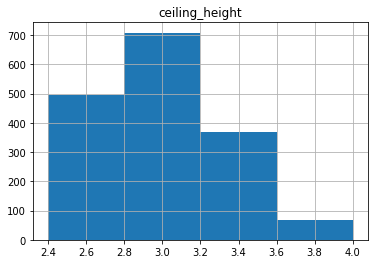

In [102]:
estate_spc.hist('ceiling_height', bins = 4)

Большая часть квартир в центре имеет высоту потолков от 2.8 метров до 3.2 метров. 

Выделим факторы, которые влияют на стоимость квартиры, отдельно для квартир в Петербурге и центре этого города. Сравним полученные значения. 

Сейчас нам необходимо провести ту же работу, что мы делали в параграфе, посвященному определению факторов, влияющих на цену квартиры, но не для всей выборки, а для центра Петербурга (estate_spc) и для Петербурга (estate_sp) в сравнении. Вспомним названия исследуемых параметров: total_area, rooms, cityCenters_nearest, floor_cat, day_exposition, month_exposition и year_exposition. Также вспомним, что у нас есть две функции: первая рисует hexbin и считает коэф. корреляции (подойдет для анализа первых трех факторов), а вторая группирует срез по выбранному параметру и строит график зависимости средней/медианной цены от параметра (здесь коэф. Пирсона надо считать отдельно, но как показал опыт - для некоторых параметров он вовсе не показателен, подойдет для крайних четырех факторов). Приступаем.

Начнем с total_area.

'Коэф. корреляции: 0.8'

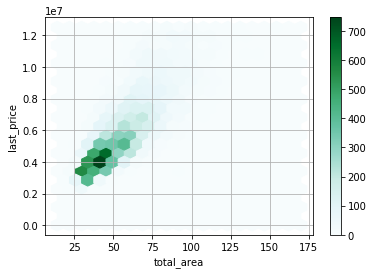

In [103]:
last_price(estate_sp, 'total_area')

'Коэф. корреляции: 0.71'

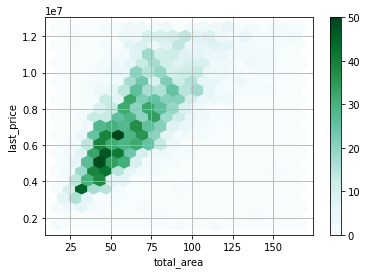

In [104]:
last_price(estate_spc, 'total_area')

Итак, что мы видим? Зависимость цены от площадь квартиры для центральной зоны меньше, чем для всего Петербурга; коэффициент корреляции меньше примерно на 10 процентов. Как это можно трактовать? Можно предположить: цену квартиры в центре Петербурга составляет не только площадь квартиры, но и факт того, что она в центре; для квартир вне центра это не актуально, поэтому для них площадь квартиры имеет большее значение.

Что же с rooms?

'Коэф. корреляции: 0.52'

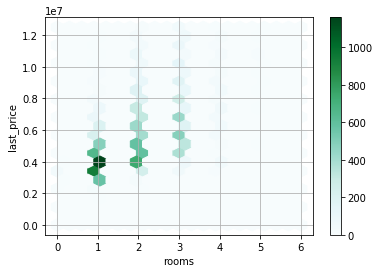

In [105]:
last_price(estate_sp, 'rooms')

'Коэф. корреляции: 0.49'

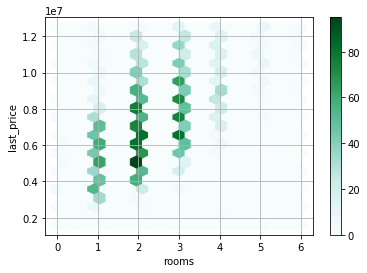

In [106]:
last_price(estate_spc, 'rooms')

Интересно, а вот зависимость от количества комнат примерно одинаковая и для центрального района, и для всего города. Видимо вопрос 'спальней большей, спальней меньше' имеет значение даже для жителей центра культурной столицы, но общая динамика та же - для центра коэффициент корреляции меньше.

Обратимся к столбцу, содержащему расстояние до центра.

'Коэф. корреляции: 0.36'

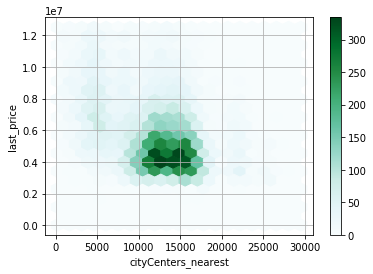

In [107]:
last_price(estate_sp, 'cityCenters_nearest')

'Коэф. корреляции: 0.21'

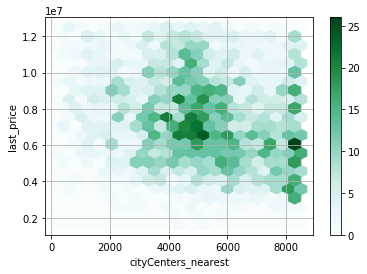

In [108]:
last_price(estate_spc, 'cityCenters_nearest')

А вот и очень интересный вывод: коэффициент корреляции для данного параметра на треть меньше для центральной зоны относительно всего города. Трактуем: когда квартира просто в Петербурге, расстояние до центра имеет некоторое значение, а вот когда она уже в центральной зоне города - этот параметр обесценивается, потому что в центре - значит в центре, и уже не имеет значение расстояние до какой-то конкретной более центральной точки. 

Исследуем зависимость от категории этажа.

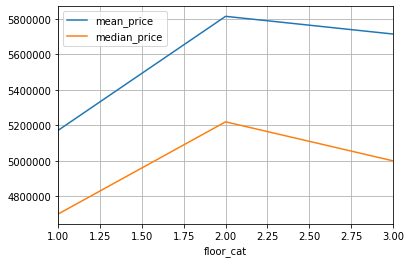

In [109]:
newdf_maker(estate_sp, 'floor_cat')

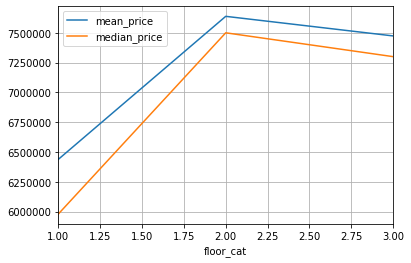

In [110]:
newdf_maker(estate_spc, 'floor_cat')

Первое, на что обратим внимание: если сравнивать эти графики с тем, что мы получили на пару параграфов выше - для floor_cat для всей таблицы, можно сделать очень необычные заключения, но это останется не озвученным до Шага 5; второе - в центре города квартиры на первом этаже стоят сильно дешевле квартир на других этажах (даже на последнем): на 1 - 1,5 млн. (!!!) рублей, чем может быть это вызвано? ну, выдвинем теорию: в центре такого города как Питер шумно и много людей, и до первого этажа этот шум и хаос доносится куда легче, чем до пятого, например, в общем, жить на первом этажа в центре Петербурга - не очень приятно, а вот для всего города - разница уже не такая большая; если исключить влияние такого 'перекоса' в центральной зоне на данные по всему городу, то, возможно, мы бы обнаружили, что для окраин это и вовсе значение не имеет; третье - разницы в цене между квартирами на других этажах и последних особо нет.

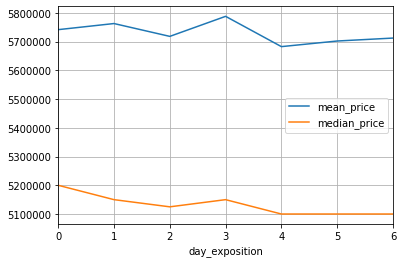

In [111]:
newdf_maker(estate_sp, 'day_exposition')

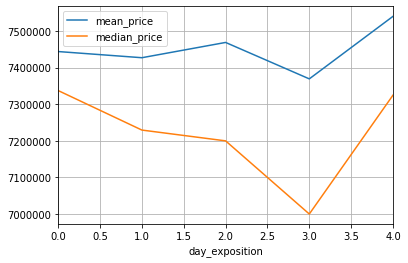

In [112]:
newdf_maker(estate_spc, 'day_exposition', [5,6])

Коэффициент корреляции для этого и последующих параметров (как и для floor_cat, кстати) мы считать не будем. Исследование выше дало нам понять, что для этих четырех факторов он не является показательным. 

Обратимся к графикам. Первое, что бросается в глаза - для всего города зависимость цены от дня публикации объявления плавная, а для центра скачкообразная и ломанная. Убедимся, что в срезе для estate_spc достаточно данных для опредения такого рода закономерностей.

In [113]:
estate_spc['day_exposition'].value_counts()

3    503
4    460
1    434
2    428
0    374
5    205
6    148
Name: day_exposition, dtype: int64

Как и ожидалось, в субботу и воскресенье меньше всего объявлений, не будем учитывать эти два дня (для estate_spc) при анализе. Посмотрим на зависимость цены от дня недели для дней от понедельника до пятницы: в целом, для центра Питера и для всего город динамика одинаковая: средние значения колеблются около одних значений; и медианные, и средние значения для обоих срезов становятся меньше к концу недели; выбивается только медиана цены для объявлений о квартирах в центре - цена сильно падает в четверг. С чем это связано - непонятно. Может у жителей центра Петербурга к четвергу не выдерживают нервы от туристов во дворах и они решают продать квартиру как можно скорее (поэтому цена низкая) и уехать? 

Посмотрим на зависимость от месяца.

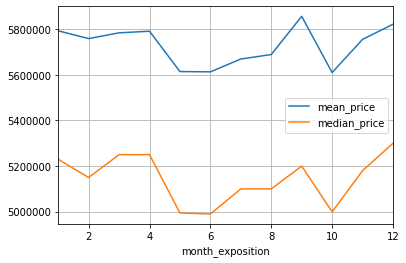

In [114]:
newdf_maker(estate_sp, 'month_exposition')

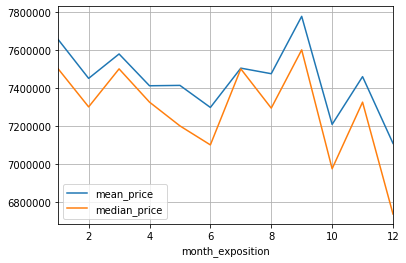

In [115]:
newdf_maker(estate_spc, 'month_exposition')

В целом, полученные графики похожи: минимальные значения в 5,6 и 10 месяцах (пока не смотрим на декабрь), максимальные в 3 и 9 месяц. Немного не совпадают данные по апрелю (4), так - в центральном районе квартиры стоят дешевле в этом месяце, чем в марте, а вот по всему городу цена остается прежней, но самое большое несовпадение - это декабрь. Невооруженным взглядом видно, что для графика об объявлениях в центре - это минимум, в то время как для графика по всему городу - максимум. Как такое может быть? Квартиры в городе растут в цене, а в центре сильно обесцениваются. Разгадка может быть в количестве объявлений, ведь известный факт - чем меньше значений, тем хуже проявляется закономерность. Проверим.

In [116]:
estate_spc['month_exposition'].value_counts()

2     271
3     257
4     250
11    246
9     236
10    222
8     202
6     201
7     199
12    172
5     149
1     147
Name: month_exposition, dtype: int64

С этим все в порядке. В чем же дело? Как и в деле с загадочным четвергом, ответа нет. Но в общем: цена квартиры в центре и во всем Петербурге зависит от месяца, для всех объявлений актуально то, что, квартиры, размещенные в мае, июне и октябре стоят дешевле всего, а объявления, сделанные в марте и сентября, продают квартиры подороже, и еще - в декабре продаются относительно более дешевые квартиры в центре и относительно менее дорогие во всем Питере.

Рассмотрим последний параметр - зависимость от года публикации объявления.

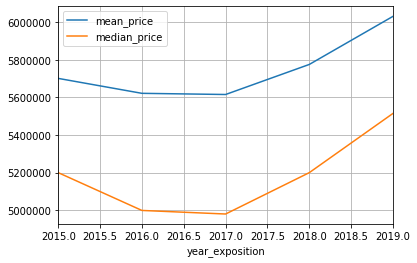

In [117]:
newdf_maker(estate_sp, 'year_exposition', [2014])

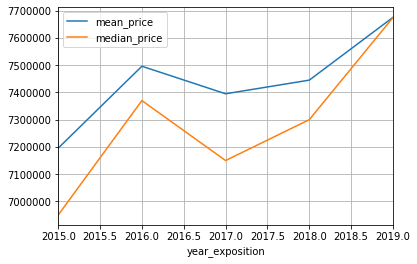

In [118]:
newdf_maker(estate_spc, 'year_exposition', [2014])

Напоминание: 2014 год мы не учитываем, да и на втором графике его вообще нет. Делаем вывод о зависимости цены квартиры от года публикации объявления для квартиры в Петербурге и для квартиры в его центре: рост цены начинается с 2017 года, так, в объявлениях 2018 года квартиры дороже, а в объявлениях от 2019 - еще дороже - это актуально для всех объявлений; различие в том, что цены на квартиру во всем городе в 2015-2017 одинаковые, а вот для квартир в центре - нет: в 2016 цена растет, а в 2017 падает. 

Чтобы сделать вывод по данному подпункту, посмотрим на нашу итоговую таблицу. Получим ее срез для Петербурга и его центральной части. 

In [119]:
estate_conq.query('area == "Санкт-Петербург" or area == "Санкт-Петербург-"')

,area,factor,coef
7,Санкт-Петербург,kilo_center,2.33
8,Санкт-Петербург,total_area,0.80
9,Санкт-Петербург-,total_area,0.71
10,Санкт-Петербург,rooms,0.52
11,Санкт-Петербург-,rooms,0.49
12,Санкт-Петербург,cityCenters_nearest,0.36
13,Санкт-Петербург-,cityCenters_nearest,0.21
14,Санкт-Петербург,floor_cat,0.21
15,Санкт-Петербург-,floor_cat,0.50
16,Санкт-Петербург,day_exposition,0.04


Удалим лишние строки - мы вызывали метод, корректирующий таблицу, только для построения графиков в некоторых случаях.

In [120]:
estate_conq = estate_conq.drop([7]).reset_index(drop=True)

In [121]:
estate_conq.query('area == "Санкт-Петербург" or area == "Санкт-Петербург-"').pivot_table(
index='factor', columns='area', values='coef', aggfunc='last'
).sort_values(by='Санкт-Петербург', ascending=False)

area,Санкт-Петербург,Санкт-Петербург-
factor,,
total_area,0.80,0.71
rooms,0.52,0.49
cityCenters_nearest,0.36,0.21
floor_cat,0.21,0.50
year_exposition,0.18,0.22
month_exposition,0.10,0.28
day_exposition,0.04,0.09


**Вывод по подпункту**: мы проделали обширную работу в данном подшаге, посмотрели, что влияет на цену квартиры в центре Санкт-Петербурга и на цену квартиры в Петербурге вообще, сравнили, теперь можем рассказать: и на то, и на другое сильнее всего влияют три фактора: площадь квартиры, количество комнат и... для квартиры в городе - удаленность от центра, а для квартиры в центре - этаж дома. Также интересно: на стоимость квартиры в центре Петербурга, если верить нашему исследованию, сильно влияет месяц публикации объявления. Остальные факторы не так существенны в данном вопросе.

**Вывод по Шагу 4'Исследовательский анализ данных'**: как видно, это самый объемный Шаг, здесь мы проделали самую важную работу: мы изучили параметры и удалили редкие и выбивающиеся значения, в этом вопросе мы применили навыки работы с диаграммами размаха и гистограммами; мы выделили, какие параметры сильнее всего влияют на цену квартиры для Петербурга и ближних населенных пунктов, а также для Петербурга только отдельно и его центра отдельно; мы определили населенный пункт с самой высокой ценой за квадратный метр и с самой низкой; мы также определили центр города, не опираясь на карту. Теперь мы можем сделать общий вывод по работе, хотя ключевые моменты прояснились уже на этом шаге.

<h3> Шаг 5: Общие выводы</h3>
<a id='conq'></a>

Итак, настало время сформулировать общий вывод по проделанной работе. Нашей первоочередной задачей было - определить, какие факторы сильнее всего влияют на стоимость квартиры. Мы исследовали, что это за факторы, для Санкт-Петербурга и ближайших населенных пунктов, просто для Петербурга отдельно и для его центра отдельно. В ходе работы собрали таблицу с названиями факторов, которые могут иметь влияние, и коэффициентами их влияния. Сравним их для трех категорий объявлений, указанных выше. Сделаем сводную таблицу.

In [122]:
estate_pivot = estate_conq.pivot_table(
index='factor', columns='area', values='coef', aggfunc='last'
)

Добавим в сводную таблицу новый столбец - средний коэффициент для каждого фактора. Напишем для этого функцию.

In [123]:
areas = estate_conq['area'].unique()
def mean_coef(row):
    mean_coef = 0
    for i in range(3): 
        mean_coef += row[areas[i]]
    return round(mean_coef/3, 2)

In [124]:
 estate_pivot['mean'] = estate_pivot.apply(mean_coef, axis=1)

In [125]:
estate_pivot.sort_values(by='mean', ascending=False)

area,Санкт-Петербург,Санкт-Петербург+,Санкт-Петербург-,mean
factor,,,,
total_area,0.80,0.71,0.71,0.74
rooms,0.52,0.45,0.49,0.49
floor_cat,0.21,0.31,0.50,0.34
cityCenters_nearest,0.36,0.35,0.21,0.31
year_exposition,0.18,0.17,0.22,0.19
month_exposition,0.10,0.12,0.28,0.17
day_exposition,0.04,0.05,0.09,0.06


Все, мы получили итоговую таблицу по проекту. То, что нужно было выяснить - как влияют различные факторы на цену квартиры. Сделаем вывод.

**Вывод по Шагу 5: Общие выводы**: сильнее всего на цену квартиры влияют следующие четыре фактора: площадь квартиры, количество комнат в ней, категория этажа: первый, другой, последний и расстояние до центра города. Если рассматривать более подробно: первый фактор - площадь, имеет одинаково большое влияние для всех местностей (чуть сильнее для Петербурга); второй - количество комнат, занимает почетное второе место в списке влияния с почти одинаковым коэффициентом также для всех типов местности; третий - категория этажа, особое, сильное влияние имеет для квартир в центре Петербурга, вспоминаем, там жить на первом этаже никто не любит (для сравнения, этот фактор имеет в два раза (!) большее влияние для центра, чем для всей таблицы (Питер и ближайшие населенные пункты)); четвертый - расстояние до центра, меньше всего влият на цену жилья в центре Петербурга (центр - есть центр). Также можно выделить дополнительно параметр 'год публикации', что весьма естественно - цены на недвижимость имеют особые тенденции в разные года.